**Modelo tipo 1 e 2**

* Tipo 1: demanda <= oferta

* Tipo 2: demanda >= oferta

* fim no cliente

In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
from math import *
from copy import deepcopy

In [2]:
qnt_orig = 5
qnt_trans = 4
qnt_port = 2
qnt_cli = 1

In [3]:
N = [i for i in range(qnt_orig)]
M = [i + qnt_orig + qnt_trans for i in range(qnt_port)]
K = [i + qnt_orig for i in range(qnt_trans)]
O = [i + qnt_orig + qnt_trans + qnt_port for i in range(qnt_cli)]

supply = {
    0: 243138,
    1: 354063,
    2: 143703,
    3: 755250,
    4: 1253270,
}

demand = { O[0]: 2749424 }

cap_transbordo = {
    K[0]: 691205,
    K[1]: 1709592,
    K[2]: 223253,
    K[3]: 125374
}

cap_port = {
    M[0]: 2577035,
    M[1]: 172389
}

In [4]:
cost = {
    (0, M[0]): 217.11, (0, M[1]): 276.58,
    (1, M[0]): 230.07, (1, M[1]): 261.53,
    (2, M[0]): 165.83, (2, M[1]): 226.65,
    (3, M[0]): 157.93, (3, M[1]): 184.61,
    (4, M[0]): 130.65, (4, M[1]): 186.55,
    
    (K[0], M[0]): 81.64, (K[0], M[1]): 153.16,
    (K[1], M[0]): 93.82, (K[1], M[1]): 141.19,
    (K[2], M[0]): 111.78, (K[2], M[1]): 123.23,
    (K[3], M[0]): 84.05, (K[3], M[1]): 111.50,
    
    (0, K[0]): 93.23, (0, K[1]): 70.72, (0, K[2]): 76.09, (0, K[3]): 102.92,
    (1, K[0]): 130.35, (1, K[1]):  112.76, (1, K[2]):  73.70, (1, K[3]):  102.62,
    (2, K[0]): 69.98, (2, K[1]):  52.39, (2, K[2]):  23.78, (2, K[3]): 45.68,
    (3, K[0]): 97.26, (3, K[1]):  89.65, (3, K[2]):  48.51, (3, K[3]): 41.06,
    (4, K[0]):  69.98, (4, K[1]):  73.70, (4, K[2]):  53.43, (4, K[3]): 24.57,
}

emission = {
    (0, M[0]): 71450.58, (0, M[1]): 92505.81,
    (1, M[0]): 76041.57, (1, M[1]): 87176.04,
    (2, M[0]): 53297.7, (2, M[1]): 74827.86,
    (3, M[0]): 50500.89, (3, M[1]): 59946.72,
    (4, M[0]): 40843.98, (4, M[1]): 60632.73,
    
    (K[0], M[0]): 54182.3179, (K[0], M[1]): 125865.2939,
    (K[1], M[0]): 66409.1727, (K[1], M[1]): 113870.6639,
    (K[2], M[0]): 84401.1177, (K[2], M[1]): 95878.7189,
    (K[3], M[0]): 56613.5582, (K[3], M[1]): 95878.7189,
    
    (0, K[0]): 27598.71, (0, K[1]): 19630.44, (0, K[2]): 21530.16, (0, K[3]): 31028.76,
    (1, K[0]): 40738.44, (1, K[1]): 34511.58, (1, K[2]): 20685.84, (1, K[3]): 30923.22,
    (2, K[0]): 19366.59, (2, K[1]): 13139.73, (2, K[2]): 3013.167, (2, K[3]): 10765.08,
    (3, K[0]): 29023.5, (3, K[1]): 26332.23, (3, K[2]): 11767.71, (3, K[3]): 9129.21,
    (4, K[0]): 19366.59, (4, K[1]): 20685.84, (4, K[2]): 13509.12, (4, K[3]): 3292.848,
}

for j in M:
    for o in O:
        cost[j, o] = 0

In [5]:
# cost = {
#     (0, M[0]): 20879, (0, M[1]): 27031,
#     (1, M[0]): 22220, (1, M[1]): 25474,
#     (2, M[0]): 15574, (2, M[1]): 21866,
#     (3, M[0]): 14757, (3, M[1]): 17517,
#     (4, M[0]): 11935, (4, M[1]): 17718,
    
#     (K[0], M[0]): 6954.5681, (K[0], M[1]): 16155.4321,
#     (K[1], M[0]): 8523.9453, (K[1], M[1]): 14615.8621,
#     (K[2], M[0]): 10833.3003, (K[2], M[1]): 12306.5071,
#     (K[3], M[0]): 7266.6298, (K[3], M[1]): 12306.5071,
    
#     (0, K[0]): 8064.66, (0, K[1]): 5736.24, (0, K[2]): 6291.36, (0, K[3]): 9066.96,
#     (1, K[0]): 11904.24, (1, K[1]): 10084.68, (1, K[2]): 6044.64, (1, K[3]): 9036.12,
#     (2, K[0]): 5659.14, (2, K[1]): 3839.58, (2, K[2]): 880.482, (2, K[3]): 3145.68,
#     (3, K[0]): 8481, (3, K[1]): 7694.58, (3, K[2]): 3438.66, (3, K[3]): 2667.66,
#     (4, K[0]): 5659.14, (4, K[1]): 6044.64, (4, K[2]): 3947.52, (4, K[3]): 962.208,
# }
# for j in M:
#     for o in O:
#         cost[j, o] = 0


In [6]:
print(f'ori: {N}\n port: {M}\n trans: {K}')

ori: [0, 1, 2, 3, 4]
 port: [9, 10]
 trans: [5, 6, 7, 8]


In [7]:
oferta_total = 0
for i in supply:
    oferta_total += supply[i]
demanda_total = 0
for i in demand:
    demanda_total += demand[i]

print(oferta_total, demanda_total)

2749424 2749424


In [8]:
m = gp.Model("probrema")

In [9]:
X = {}
for i in N:
    for j in M:
        X[i, j] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="supply_{}_port_{}".format(i, j))

for i in N:
    for k in K:
        X[i, k] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="supply_{}_tranship_{}".format(i, k))
                
for j in M:
    for k in K:
        X[k, j] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="tranship_{}_port_{}".format(k, j))

for j in M:
    for o in O:
        X[j, o] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="X_{}_{}".format(j, o))

In [10]:
m.setObjectiveN(
    gp.quicksum((X[i, j] * cost[i, j]) for i in N for j in M) + \
    gp.quicksum((X[i, k] * cost[i, k]) for i in N for k in K) + \
    gp.quicksum((X[k, j] * cost[k, j]) for j in M for k in K),
    0,
    priority=2,
    name="Funcao Frete"
)

In [11]:
m.setObjectiveN(
    gp.quicksum((X[i, j] * emission[i, j]) for i in N for j in M) + \
    gp.quicksum((X[i, k] * emission[i, k]) for i in N for k in K) + \
    gp.quicksum((X[k, j] * emission[k, j]) for j in M for k in K),
    1,
    priority=1,
    name="Funcao Emissao CO2"
)

In [12]:
if oferta_total <= demanda_total:
    for i in N:
        m.addConstr(
            (gp.quicksum(X[i, j] for j in M) + gp.quicksum(X[i, k] for k in K)) == supply[i]
        )
else:
    for i in N:
        m.addConstr(
            (gp.quicksum(X[i, j] for j in M) + gp.quicksum(X[i, k] for k in K)) <= supply[i]
        )

In [13]:
if oferta_total <= demanda_total:
    for o in O:
        m.addConstr(
            gp.quicksum(X[j, o] for j in M) <= demand[o]
        )
else:
    for o in O:
        m.addConstr(
            gp.quicksum(X[j, o] for j in M) == demand[o]
        )

In [14]:
for j in M:
    m.addConstr(
        (gp.quicksum(X[i, j] for i in N) + gp.quicksum(X[k, j] for k in K)) <= cap_port[j]
    )

for k in K:
    m.addConstr(
        gp.quicksum(X[i, k] for i in N) <= cap_transbordo[k]
    )

for k in K:
    m.addConstr(
        gp.quicksum(X[i, k] for i in N) == gp.quicksum(X[k, j] for j in M)
    )

for j in M:
    m.addConstr(
        gp.quicksum(X[j, o] for o in O) == (gp.quicksum(X[i, j] for i in N) + gp.quicksum(X[k, j] for k in K))
    )

In [15]:
rest = m.addConstrs(
    gp.quicksum(X[i, j] for i in N) >= 0 for j in M
)

rest = m.addConstrs(
    gp.quicksum(X[i, k] for i in N) >= 0 for k in K
)

rest = m.addConstrs(
    gp.quicksum(X[k, j] for k in K) >= 0 for j in M
)

In [16]:
m.Params.Method = -1

In [17]:
vals = []

In [18]:
m.setParam('TimeLimit', 60*9)
m.setParam(gp.GRB.Param.Threads, 1)
m.Params.LogToConsole = 0

Set parameter TimeLimit to value 540
Set parameter Threads to value 1


In [19]:
m.update()
m.optimize()

In [20]:
m.write('out.sol')

In [21]:
# Executa o modelo
cnt = 0
m.params.ObjNumber = 1
last = m.ObjNVal
m.params.ObjNumber = 0
while m.Status == gp.GRB.OPTIMAL:
    cnt += 1
    obj1 = m.ObjNVal
    m.params.ObjNumber = 1
    obj2 = m.ObjNVal
    m.params.ObjNumber = 0
    if obj2 - last > 1e-6: break
    last = obj2
    vals.append([obj1, obj2])
    m.addConstr(
        (gp.quicksum((X[i, j] * cost[i, j]) for i in N for j in M) + \
        gp.quicksum((X[i, k] * cost[i, k]) for i in N for k in K) + \
        gp.quicksum((X[k, j] * cost[k, j]) for j in M for k in K)) >= obj1 + 5e5,
        "restri_pareto"
    )
    m.update()
    m.optimize()
    restricao_a_remover = m.getConstrByName("restri_pareto")
    m.remove(restricao_a_remover)

In [22]:
obj1, last

(446323875.7600001, 142958845331.20044)

In [23]:
#m.write("out.sol")

In [24]:
cap_inf = 408350021.71000004
cap_dem = 410323875.76000011

In [25]:
m.Status == gp.GRB.OPTIMAL

True

In [26]:
vals

[[410323875.76, 162232216963.24942],
 [410823875.76, 161123547222.7382],
 [411323875.76, 160014877482.227],
 [411823875.76, 158906207741.71573],
 [412323875.75999993, 158132944071.833],
 [412823875.75999993, 157463953177.33768],
 [413323875.75999993, 156794962282.84225],
 [413823875.7599999, 156125971388.34683],
 [414323875.7599998, 155456980493.8515],
 [414823875.7599998, 154804287466.27487],
 [415323875.7599998, 154452776588.747],
 [415823875.7599998, 154127082624.85376],
 [416323875.7599998, 153801388660.9605],
 [416823875.7599998, 153475694697.06726],
 [417323875.7599998, 153171925426.8086],
 [417823875.7599999, 152912169835.86908],
 [418323875.7599999, 152652414244.92957],
 [418823875.7599999, 152392658653.99008],
 [419323875.7599999, 152132903063.0506],
 [419823875.7599998, 151873147472.11115],
 [420323875.7599998, 151613391881.1717],
 [420823875.75999975, 151353636290.23218],
 [421323875.7599997, 151093880699.29272],
 [421823875.7599997, 150834125108.35327],
 [422323875.75999963

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt

In [28]:
x = np.zeros(len(vals))
y = np.zeros(len(vals))
for i in range(len(vals)):
    x[i], y[i] = vals[i]

Text(0, 0.5, 'Emissao CO2')

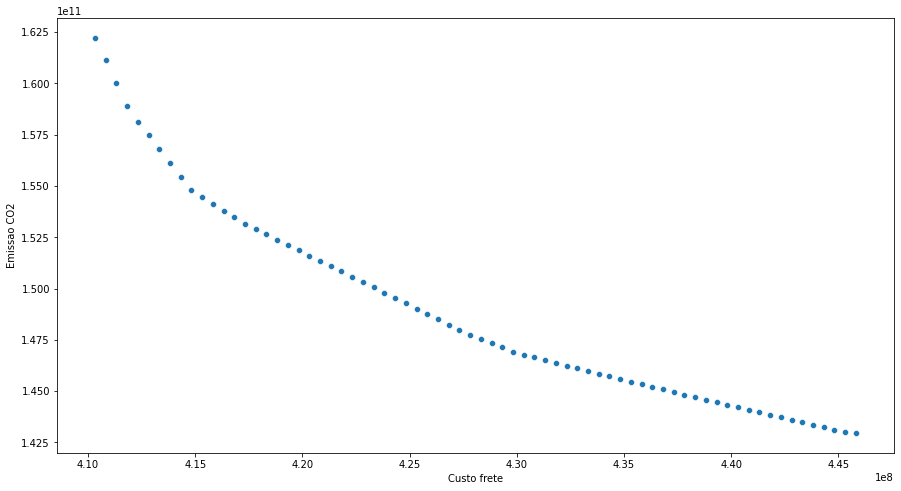

In [29]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(x=x, y=y)
ax.set_xlabel('Custo frete')
ax.set_ylabel('Emissao CO2')